## The Tic-Tac-Toe environment

The [Tic-Tac-Toe](https://github.com/MauroLuzzatto/OpenAI-Gym-TicTacToe-Environment) is a simple game environment that allows to train reinforcement learning agents.

In [51]:
from IPython.display import Image

Image(
    url="https://img.poki.com/cdn-cgi/image/quality=78,width=600,height=600,fit=cover,f=auto/85535e05d1f130b16751c8308cfbb19b.png",
    width=300,
)

In [52]:
# load the python modules
import time
import sys
import warnings

import gym
import numpy as np
from tqdm import tqdm
import gym_TicTacToe

from src.qagent import Qagent
from src.player import Player
from src.play_tictactoe import play_tictactoe

from src.utils import (
    create_state_dictionary,
    reshape_state,
    save_qtable,
)

# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [53]:
# initialize the tictactoe environment
env = gym.envs.make("TTT-v0", small=-1, large=10)

In [54]:
# get 10 randomly sampled actions
[env.action_space.sample() for ii in range(10)]

[0, 4, 1, 1, 8, 4, 7, 1, 3, 1]

In [55]:
[env.observation_space.sample() for ii in range(10)]

[93, 3111, 2699, 4028, 6537, 6164, 8671, 8927, 8927, 940]

In [56]:
env.reset()
print(env.render())

╒═══╤═══╤═══╕
│ - │ - │ - │
├───┼───┼───┤
│ - │ - │ - │
├───┼───┼───┤
│ - │ - │ - │
╘═══╧═══╧═══╛


In [57]:
color = 1
action = 4

new_state, reward, done, _ = env.step((action, color))
print(new_state, reward, done)
print(env.render())

[[0 0 0]
 [0 1 0]
 [0 0 0]] -1 False
╒═══╤═══╤═══╕
│ - │ - │ - │
├───┼───┼───┤
│ - │ X │ - │
├───┼───┼───┤
│ - │ - │ - │
╘═══╧═══╧═══╛


In [58]:
state_dict = create_state_dictionary()
state_size = env.observation_space.n
action_size = env.action_space.n

Number of legal states: 8953


In [59]:
# set training parameters
episodes = 60_000  # 10**6 * 2
max_steps = 9

# name of the qtable when saved
load = False
save = True
test = True

num_test_games = 1

In [60]:
learning_parameters = {"learning_rate": 1.0, "gamma": 0.9}
exploration_parameters = {
    "max_epsilon": 1.0,
    "min_epsilon": 0.0,
    "decay_rate": 0.00001,
}

name = f"qtable_{episodes}"
folder = "tables"

In [61]:
qagent = Qagent(state_size, action_size, learning_parameters, exploration_parameters)

In [62]:

def play(qagent:Qagent, player: Player, state: int, action_space: np.array) -> tuple:
    """this function contains the one round of game play for one player

    Args:
        qagent (Qagent): qagent to play to game
        player (Player): player class that has its turn
        state (int): number of the current state
        action_space (np.arry): array with all available actions

    Returns:
        tuple: state, action_space, done
    """
    action = qagent.get_action(state, action_space)

    # remove action from the action space
    action_space = action_space[action_space != action]

    new_state, reward, done, _ = env.step((action, player.color))
    new_state = state_dict[reshape_state(new_state)]

    qagent.qtable[state, action] = qagent.update_qtable(
        state, new_state, action, reward, done
    )
    # new state
    state = new_state
    player.add_reward(reward)
    return state, action_space, done

In [63]:

start_time = time.time()

player_1 = Player(color=1, episodes=episodes)
player_2 = Player(color=2, episodes=episodes)

track_progress = np.zeros(episodes)

for episode in tqdm(range(episodes)):
    state = env.reset()
    state = state_dict[reshape_state(state)]

    action_space = np.arange(9)

    player_1.reset_reward()
    player_2.reset_reward()

    # randomly change the order players
    # to start the game, integer either 0 or 1
    start = np.random.randint(2)

    for _step in range(start, max_steps + start):

        # alternate the moves of the players
        if _step % 2 == 0:
            state, action_space, done = play(qagent, player_1, state, action_space)
        else:
            state, action_space, done = play(qagent, player_2, state, action_space)

        if done == True:
            break

    # reduce epsilon for exporation-exploitation tradeoff
    qagent.update_epsilon(episode)
    player_1.save_reward(episode)
    player_2.save_reward(episode)
    
    track_progress[episode] = np.sum(qagent.qtable)


    if episode % 1_0000 == 0:

        sum_q_table = np.sum(qagent.qtable)
        time_passed = round((time.time() - start_time) / 60.0, 2)

        print(
            f"episode: {episode}, \
            epsilon: {round(qagent.epsilon, 2)}, \
            sum q-table: {sum_q_table}, \
            elapsed time [min]: {time_passed},  \
            done [%]: {episode / episodes * 100} \
            "
        )


  0%|          | 33/60000 [00:00<03:19, 299.99it/s]

episode: 0,             epsilon: 1.0,             sum q-table: 1.0,             elapsed time [min]: 0.0,              done [%]: 0.0             


 17%|█▋        | 10029/60000 [00:26<02:28, 336.07it/s]

episode: 10000,             epsilon: 0.9,             sum q-table: 97043.65127000002,             elapsed time [min]: 0.45,              done [%]: 16.666666666666664             


 33%|███▎      | 20068/60000 [00:56<01:34, 423.33it/s]

episode: 20000,             epsilon: 0.82,             sum q-table: 137448.83492,             elapsed time [min]: 0.94,              done [%]: 33.33333333333333             


 50%|█████     | 30056/60000 [01:21<01:23, 356.95it/s]

episode: 30000,             epsilon: 0.74,             sum q-table: 147525.58380000002,             elapsed time [min]: 1.35,              done [%]: 50.0             


 67%|██████▋   | 40094/60000 [01:47<00:46, 425.37it/s]

episode: 40000,             epsilon: 0.67,             sum q-table: 150693.2545,             elapsed time [min]: 1.79,              done [%]: 66.66666666666666             


 83%|████████▎ | 50055/60000 [02:20<00:26, 377.00it/s]

episode: 50000,             epsilon: 0.61,             sum q-table: 152373.162,             elapsed time [min]: 2.34,              done [%]: 83.33333333333334             


100%|██████████| 60000/60000 [02:46<00:00, 359.98it/s]


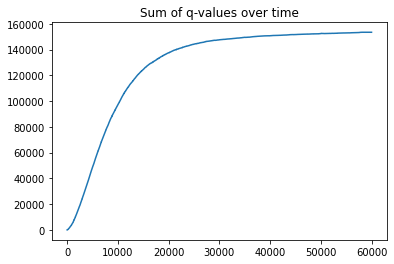

In [64]:
import matplotlib.pyplot as plt
plt.title("Sum of q-values over time")
plt.plot(range(episodes), track_progress)
plt.show()

In [65]:
qtable = qagent.qtable
save_qtable(qtable, folder, name)

qtable_60000.npy saved!


In [68]:
# test the algorithm with playing against it
play_tictactoe(env, qtable, state_dict, num_test_games=1)

Agent beginns
--------------------
--------------------
move Agent
Action: 0


╒═══╤═══╤═══╕
│ O │ - │ - │
├───┼───┼───┤
│ - │ - │ - │
├───┼───┼───┤
│ - │ - │ - │
╘═══╧═══╧═══╛
--------------------
Move Human
Action: 4
-1


--------------------
move Agent
Action: 1


╒═══╤═══╤═══╕
│ O │ O │ - │
├───┼───┼───┤
│ - │ X │ - │
├───┼───┼───┤
│ - │ - │ - │
╘═══╧═══╧═══╛
--------------------
Move Human
Action: 2
-1


--------------------
move Agent
Action: 6


╒═══╤═══╤═══╕
│ O │ O │ X │
├───┼───┼───┤
│ - │ X │ - │
├───┼───┼───┤
│ O │ - │ - │
╘═══╧═══╧═══╛
--------------------
Move Human
Action: 5
-1


--------------------
move Agent
Action: 7


╒═══╤═══╤═══╕
│ O │ O │ X │
├───┼───┼───┤
│ - │ X │ X │
├───┼───┼───┤
│ O │ O │ - │
╘═══╧═══╧═══╛
--------------------
Move Human
Action: 8
9
********************
Human won!
********************
╒═══╤═══╤═══╕
│ O │ O │ X │
├───┼───┼───┤
│ - │ X │ X │
├───┼───┼───┤
│ O │ O │ X │
╘═══╧═══╧═══╛



